In [1]:
import keras
from keras.layers import Input, Dense, Flatten, Conv1D, GRU, Dropout
from keras.models import load_model, Model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from train import parse_config, get_features

from models.models import gru_model

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config  outputDir ")
options = Option(
    inputModel = 'KERAS_gru_model_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_gru.yml',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')

yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]
#features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_costhetarel','j1_pdgid','j1_pt']
#labels = ['j_g','j_q','j_w','j_z','j_t']

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df


,j1_ptrel,j1_erel,j_t,j_z,j1_phirot,j_index,j_q,j_g,j_w,j1_deltaR,j1_etarot,j1_pdgid
0,0.386118,0.382772,0,0,0.000000,101333,0,1,0,0.011056,0.000000,130.0
1,0.107734,0.105703,0,0,0.007236,101333,0,1,0,0.023104,-0.009859,211.0
2,0.094731,0.094339,0,0,-0.002759,101333,0,1,0,0.006306,0.004508,321.0
3,0.042086,0.042913,0,0,-0.014909,101333,0,1,0,0.022473,0.028567,211.0
4,0.039412,0.038547,0,0,-0.003745,101333,0,1,0,0.025492,-0.018020,-211.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5131608,0.000350,0.000344,0,1,-0.315306,300123134,0,0,0,0.380018,-0.300495,111.0
5131609,0.000258,0.000256,0,1,-0.349366,300123134,0,0,0,0.294476,0.258936,111.0
5131610,0.000219,0.000215,0,1,-0.270430,300123134,0,0,0,0.255231,0.269149,111.0
5131611,0.000116,0.000115,0,1,-0.341398,300123134,0,0,0,0.319973,-0.213081,111.0


In [8]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

C:\Users\jjren\GRU\train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

In [9]:
l1Reg =  0.0001
l1RegR = 0.001

Inputs = Input(shape = (20,6,))

x = GRU(20,kernel_regularizer=l1(l1Reg),recurrent_regularizer=l1(l1RegR),activation='relu', recurrent_activation='sigmoid', name='gru_selu',)(Inputs)
x = Dense(20,kernel_regularizer=l1(l1Reg),activation='relu', kernel_initializer='lecun_uniform', name='dense_relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1680      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,205
Trainable params: 2,205
Non-trainable params: 0
_________________________________________________________________


In [10]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(X_train_val, y_train_val, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
1852/1852 [==============================] - 16s 8ms/step - loss: 1.1948 - accuracy: 0.5500 - val_loss: 1.0185 - val_accuracy: 0.6491
Epoch 2/100
1852/1852 [==============================] - 15s 8ms/step - loss: 1.0179 - accuracy: 0.6513 - val_loss: 0.9701 - val_accuracy: 0.6681
Epoch 3/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9797 - accuracy: 0.6672 - val_loss: 0.9620 - val_accuracy: 0.6663
Epoch 4/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9552 - accuracy: 0.6788 - val_loss: 0.9243 - val_accuracy: 0.6862
Epoch 5/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9396 - accuracy: 0.6855 - val_loss: 0.9118 - val_accuracy: 0.6935
Epoch 6/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9238 - accuracy: 0.6896 - val_loss: 0.9026 - val_accuracy: 0.6942
Epoch 7/100
1852/1852 [==============================] - 15s 8ms/step - loss: 0.9154 - accuracy: 0.6929 - val_loss: 0.9279 -

Epoch 57/100
1852/1852 [==============================] - 13s 7ms/step - loss: 0.8463 - accuracy: 0.7153 - val_loss: 0.8499 - val_accuracy: 0.7100
Epoch 58/100
1852/1852 [==============================] - 13s 7ms/step - loss: 0.8454 - accuracy: 0.7152 - val_loss: 0.8395 - val_accuracy: 0.7143
Epoch 59/100
1852/1852 [==============================] - 13s 7ms/step - loss: 0.8464 - accuracy: 0.7152 - val_loss: 0.8259 - val_accuracy: 0.7185
Epoch 60/100
1852/1852 [==============================] - 13s 7ms/step - loss: 0.8467 - accuracy: 0.7168 - val_loss: 0.8216 - val_accuracy: 0.7221
Epoch 61/100
1852/1852 [==============================] - 13s 7ms/step - loss: 0.8440 - accuracy: 0.7164 - val_loss: 0.8376 - val_accuracy: 0.7160
Epoch 62/100
1852/1852 [==============================] - 13s 7ms/step - loss: 0.8456 - accuracy: 0.7162 - val_loss: 0.8376 - val_accuracy: 0.7189
Epoch 63/100
1852/1852 [==============================] - 13s 7ms/step - loss: 0.8447 - accuracy: 0.7153 - val_loss: 0

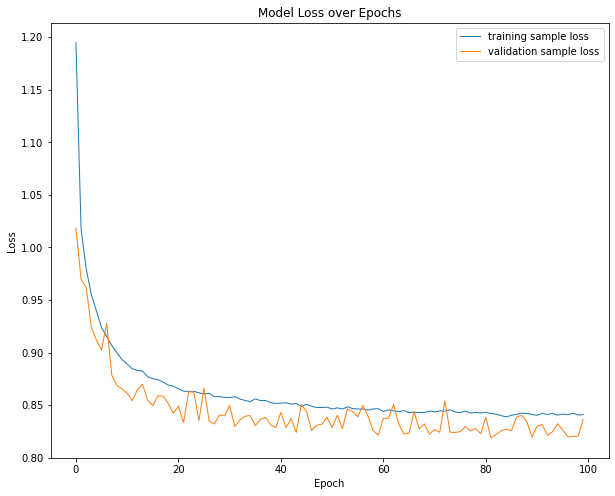

In [12]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)

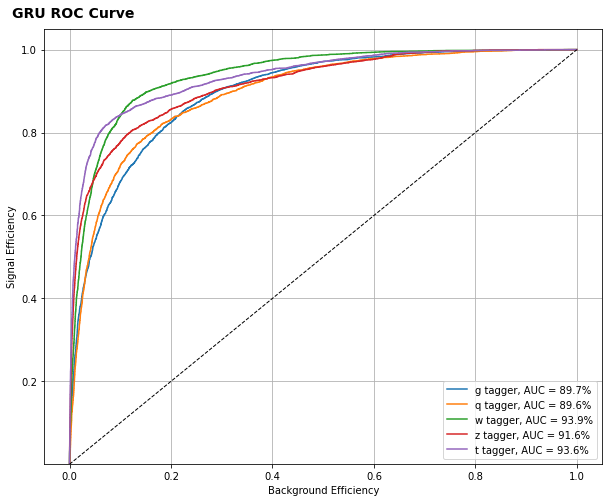

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'GRU ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')

Text(0.25, 0.9, 'GRU')

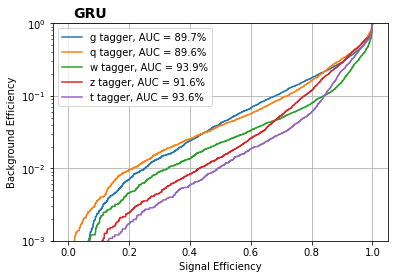

In [15]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'GRU',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)